In [15]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd

In [16]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/10000_PHASE1/"
SELECTED_CLASS = "10000_CA_Class.csv"
SELECTED_LABEL = "Is CA_Lung"
SUB = 'CA Lung'
LABEL="CA_fix1_"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob(SUB+'/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['Yes' 'No']


In [17]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + SUB + "/train/"
VALID_PATH = PATH + SUB + "/valid/"
TEST_PATH = PATH + SUB + "/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  color_mode='rgb')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 color_mode='rgb')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 color_mode='rgb')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
#Load pre-trained InceptionV3 MODEL
myInception = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/4",trainable = False)

myModel = tf.keras.Sequential([
    myInception,
    layers.Dropout(0.4),
    layers.Dense(128,activation='relu'),
    layers.Dense(2,activation='softmax')
])
myModel.build([None,224,224,3])

In [26]:
myModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   multiple                  23853833  
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  128256    
_________________________________________________________________
dense_17 (Dense)             multiple                  258       
Total params: 23,982,347
Trainable params: 128,514
Non-trainable params: 23,853,833
_________________________________________________________________


In [27]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=5,verbose=1)
myCheckpoint = ModelCheckpoint('Model2/'+LABEL+'IncpV3.hdf5',
                               monitor='val_loss',
                              save_best_only=True)
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [28]:
myModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.SGD(lr=1e-5)
                ,metrics=['accuracy'])

In [29]:
TRAIN_IMG = 8000
TEST_IMG = 1000
VALID_IMG = 1000

In [30]:
#Training myModel
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
VALID_STEP = np.ceil(VALID_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 50,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 1,
                               callbacks=[myEarly,myCheckpoint,myStop])

myModel.save('Model2/'+LABEL+'Incep3_done.h5')

Train for 250.0 steps, validate for 32.0 steps
Epoch 1/50
250/250 [==============================] - 28s 113ms/step - loss: 0.9828 - accuracy: 0.6490 - val_loss: 0.6836 - val_accuracy: 0.7410
Epoch 2/50
250/250 [==============================] - 23s 91ms/step - loss: 0.8972 - accuracy: 0.6990 - val_loss: 0.6605 - val_accuracy: 0.7770
Epoch 3/50
250/250 [==============================] - 23s 90ms/step - loss: 0.8534 - accuracy: 0.7226 - val_loss: 0.6562 - val_accuracy: 0.7880
Epoch 4/50
250/250 [==============================] - 23s 90ms/step - loss: 0.8317 - accuracy: 0.7399 - val_loss: 0.6559 - val_accuracy: 0.7980
Epoch 5/50
250/250 [==============================] - 23s 92ms/step - loss: 0.8265 - accuracy: 0.7465 - val_loss: 0.6556 - val_accuracy: 0.8050
Epoch 6/50
250/250 [==============================] - 23s 91ms/step - loss: 0.8382 - accuracy: 0.7448 - val_loss: 0.6547 - val_accuracy: 0.8070
Epoch 7/50
250/250 [==============================] - 23s 91ms/step - loss: 0.8125 - acc

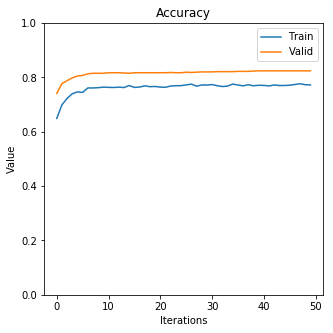

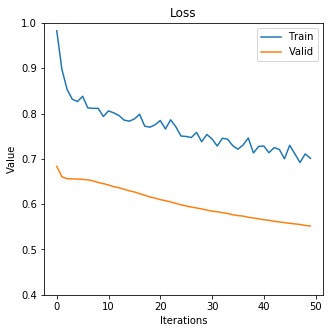

In [31]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.ylim(0,1)
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result/'+LABEL+"InceptV3_Acc.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.ylim(0.4,1)
plt.legend(['Train','Valid'])
plt.savefig('Run_Result/'+LABEL+"InceptV3_Loss.png")
plt.show()

In [12]:
y_pred = myModel.predict(datan_gen_test)
from sklearn.metrics import confusion_matrix
pred = np.argmax(y_pred,axis=1)
confusion_matrix(data_gen_test.classes,pred)